In [2]:
# Import Libraries
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Load adds data
df_adds = pd.read_csv('provided-reasources/DataAnalyst_Ecom_data_addsToCart.csv')

df_adds.head()

,dim_year,dim_month,addsToCart
0,2012,7,191504
1,2012,8,217666
2,2012,9,123726
3,2012,10,139803
4,2012,11,186572


In [4]:
# Load session data
df_ses = pd.read_csv('provided-reasources/DataAnalyst_Ecom_data_sessionCounts.csv')

df_ses.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY
0,Safari,tablet,7/1/12,2928,127,221
1,Internet Explorer,desktop,7/1/12,1106,28,0
2,Chrome,tablet,7/1/12,474,3,13
3,Amazon Silk,tablet,7/1/12,235,4,5
4,Internet Explorer,mobile,7/1/12,178,6,11


In [5]:
# Extract date time, and format month names
for i in df_ses.index:
    date = df_ses.loc[i,'dim_date']
    dt = datetime.strptime(date, "%m/%d/%y")   
    df_ses.loc[i,'dt'] = dt
    df_ses.loc[i,'month'] = str(dt.year) + '-' + str(dt.strftime('%m'))

df_ses.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY,dt,month
0,Safari,tablet,7/1/12,2928,127,221,2012-07-01,2012-07
1,Internet Explorer,desktop,7/1/12,1106,28,0,2012-07-01,2012-07
2,Chrome,tablet,7/1/12,474,3,13,2012-07-01,2012-07
3,Amazon Silk,tablet,7/1/12,235,4,5,2012-07-01,2012-07
4,Internet Explorer,mobile,7/1/12,178,6,11,2012-07-01,2012-07


In [6]:
# Explore the browser values 
browsers = df_ses[['dim_browser','sessions', 'transactions','QTY']].groupby('dim_browser').sum()
browsers.sort_values('sessions', ascending=False, inplace=True)

browsers

,sessions,transactions,QTY
dim_browser,,,
Safari,5952256,140847,263776
Chrome,2527254,66247,125468
Safari (in-app),518573,3046,5113
Firefox,495779,17376,31279
Internet Explorer,469325,14373,11016
Edge,246329,6338,11814
Android Webview,98408,289,406
Samsung Internet,56632,456,774
Amazon Silk,35379,524,836


In [9]:
# Create a list of "user browsers" with browsers that were used in transactions
    # Note: The omitted browsers are likely bots or webscrappers, and should
    # not be counted as user sessions. Identifying and removing these sessions
    # will make the data more useful to the client

browsers = df_ses[['dim_browser','sessions', 'transactions','QTY']].groupby('dim_browser').sum()
user_browsers = list(browsers[(browsers['transactions'] > 0) & (browsers['QTY'] > 0)].index)

print('Initial size of Sessions Data', df_ses.shape)

clean = df_ses.drop(df_ses[~df_ses['dim_browser'].isin(user_browsers)].index)
clean.rename(columns={'sessions':'user_sessions'}, inplace=True)
df_ses.rename(columns={'sessions':'all_sessions'}, inplace=True)

print('Size of Clean Sessions Data', clean.shape)

Initial size of Sessions Data (7734, 8)
Size of Clean Sessions Data (6609, 8)


In [10]:
# Create sheet1 with a groupby function
sheet1 = df_ses[['dim_deviceCategory', 'transactions', 'QTY', 'month', 'all_sessions']].groupby(by=['month', 'dim_deviceCategory']).sum()

# Add a column containing the session data from non-suspect browsers
    # Note: Because of the method used to identify suspect browsers, 
    # removing them only effects session data, so alternate values for
    # transactions and quantity don't need to be included
    
user_sessions = clean[['dim_deviceCategory', 'user_sessions', 'month']].groupby(by=['month', 'dim_deviceCategory']).sum()
sheet1 = sheet1.join(user_sessions)

# Add an ECR column
sheet1['ECR'] = sheet1['transactions'] / sheet1['user_sessions']

sheet1.head()

transactions    QTY  all_sessions  user_sessions  \
month   dim_deviceCategory                                                     
2012-07 desktop                    10701  18547        335429         335119   
        mobile                      2576   4557        274443         274388   
        tablet                      4884   8700        158717         158712   
2012-08 desktop                    12912  23316        392079         391557   
        mobile                      3165   5572        275556         275513   

                                 ECR  
month   dim_deviceCategory            
2012-07 desktop             0.031932  
        mobile              0.009388  
        tablet              0.030773  
2012-08 desktop             0.032976  
        mobile              0.011488

Text(0.5, 0, 'Month')

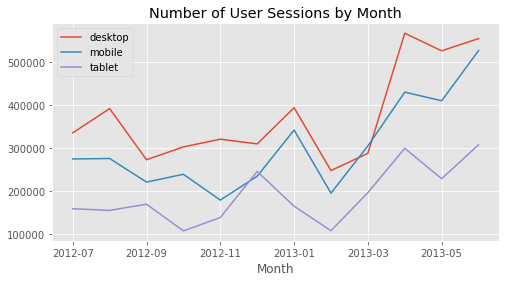

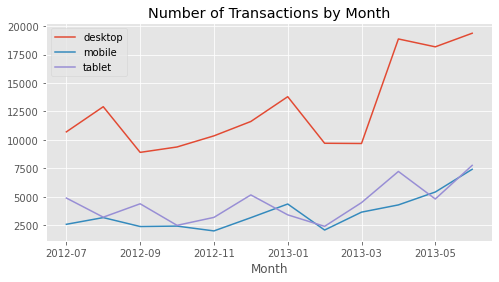

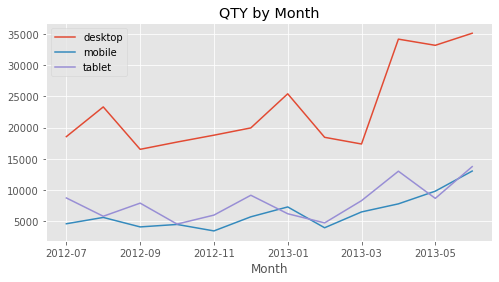

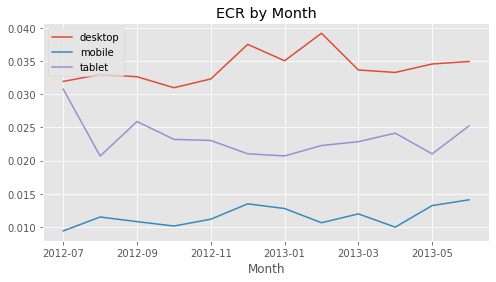

In [8]:
# Graph sessions, transactions, QTY, and ECR data over time for each platform
graph1 = sheet1.reset_index()

sessions = graph1.drop(['dim_deviceCategory', 'user_sessions', 'transactions', 'QTY', 'ECR'], axis=1)
transactions = graph1.drop(['dim_deviceCategory', 'user_sessions', 'transactions', 'QTY', 'ECR'], axis=1)
qty = graph1.drop(['dim_deviceCategory', 'user_sessions', 'transactions', 'QTY', 'ECR'], axis=1)
ecr = graph1.drop(['dim_deviceCategory', 'user_sessions', 'transactions', 'QTY', 'ECR'], axis=1)

for i in graph1.index:
    if graph1.loc[i,'dim_deviceCategory'] == 'desktop':
        sessions.loc[i,'desktop'] = graph1.loc[i,'user_sessions']
        transactions.loc[i,'desktop'] = graph1.loc[i,'transactions']
        qty.loc[i,'desktop'] = graph1.loc[i,'QTY']
        ecr.loc[i,'desktop'] = graph1.loc[i,'ECR']

    if graph1.loc[i,'dim_deviceCategory'] == 'mobile':
        sessions.loc[i-1,'mobile'] = graph1.loc[i,'user_sessions']
        transactions.loc[i-1,'mobile'] = graph1.loc[i,'transactions']
        qty.loc[i-1,'mobile'] = graph1.loc[i,'QTY']
        ecr.loc[i-1,'mobile'] = graph1.loc[i,'ECR']

    if graph1.loc[i,'dim_deviceCategory'] == 'tablet':
        sessions.loc[i-2,'tablet'] = graph1.loc[i,'user_sessions']
        transactions.loc[i-2,'tablet'] = graph1.loc[i,'transactions']
        qty.loc[i-2,'tablet'] = graph1.loc[i,'QTY']
        ecr.loc[i-2,'tablet'] = graph1.loc[i,'ECR']

sessions.dropna(inplace=True)
sessions.set_index(['month'], inplace=True)
sessions[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('Number of User Sessions by Month')
plt.xlabel('Month')

transactions.dropna(inplace=True)
transactions.set_index(['month'], inplace=True)
transactions[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('Number of Transactions by Month')
plt.xlabel('Month')

qty.dropna(inplace=True)
qty.set_index(['month'], inplace=True)
qty[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('QTY by Month')
plt.xlabel('Month')

ecr.dropna(inplace=True)
ecr.set_index(['month'], inplace=True)
ecr[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('ECR by Month')
plt.xlabel('Month')


In [9]:
# Create sheet2 using a grouby function
sheet2 = df_ses[['transactions', 'QTY', 'month', 'all_sessions']].groupby(by=['month']).sum()

# Add a column containing the session data from non-suspect browsers
    # Note: Because of the method used to identify suspect browsers, 
    # removing them only effects session data, so alternate values for
    # transactions and quantity don't need to be included
user_sessions = clean[['user_sessions', 'month']].groupby(by=['month']).sum()
sheet2 = sheet2.join(user_sessions)

# Get the data concerning the two most recent months
sheet2.sort_index(ascending=False, inplace=True)
sheet2 = sheet2.head(2)

# Create a column for ECR
sheet2['ECR'] = sheet2['transactions'] / sheet2['user_sessions']

# Add the data from df_adds
sheet2.reset_index(inplace=True)

for i in sheet2.index:
    date = sheet2.loc[i,'month'].split('-')
    year = int(date[0])
    month = int(date[1])
    x = df_adds[(df_adds['dim_year'] == year) & (df_adds['dim_month'] == month)]['addsToCart'].to_list()[0]
    sheet2.loc[i,'addsToCart'] = x

# Format the sheet to display month names and differneces
sheet2 = sheet2.transpose()

month0 = sheet2.loc['month',0]
month1 = sheet2.loc['month',1]
sheet2.rename(columns = {0:month0, 1:month1}, inplace = True)

sheet2.drop(['month'], inplace=True)
sheet2['absolute_dif'] = sheet2[month0] - sheet2[month1]
sheet2['relative_dif'] = sheet2['absolute_dif'] / sheet2[month1]

sheet2

,2013-06,2013-05,absolute_dif,relative_dif
transactions,34538,28389,6149,0.216598
QTY,61891,51629,10262,0.198764
all_sessions,1388834,1164639,224195,0.192502
user_sessions,1388177,1164123,224054,0.192466
ECR,0.02488,0.024387,0.000494,0.020237
addsToCart,107970.0,136720.0,-28750.0,-0.210284


In [10]:
# Create sheet3 containing a breakdown of session data by day of the week
sheet3 = df_ses[['dim_deviceCategory', 'transactions', 'QTY', 'all_sessions', 'dt']].copy()
sheet3 = sheet3.join(clean['user_sessions'])

sheet3['weekday_no'] = pd.DatetimeIndex(sheet3['dt']).weekday
sheet3 = sheet3[['transactions', 'QTY', 'all_sessions', 'user_sessions', 'weekday_no']].groupby('weekday_no').mean()

# Add ECR column
sheet3['ECR'] = sheet3['transactions'] / sheet3['user_sessions']

# Reformat the days of the week for readability
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in sheet3.index:
    sheet3.loc[i,'weekday'] = weekdays[i]

sheet3.set_index('weekday', inplace=True)

sheet3

,transactions,QTY,all_sessions,user_sessions,ECR
weekday,,,,,
Mon,28.913636,51.624545,1224.488182,1412.352571,0.020472
Tue,28.677389,52.263009,1216.729423,1397.301087,0.020523
Wed,31.917273,58.473636,1424.319091,1653.814150,0.019299
Thu,33.477355,60.895833,1436.522645,1653.127216,0.020251
Fri,33.609645,61.528662,1393.458599,1590.919958,0.021126
Sat,37.885317,67.244136,1435.692441,1648.504990,0.022982
Sun,31.101514,55.416741,1290.585931,1501.227979,0.020717


Text(0.5, 0, 'Weekday')

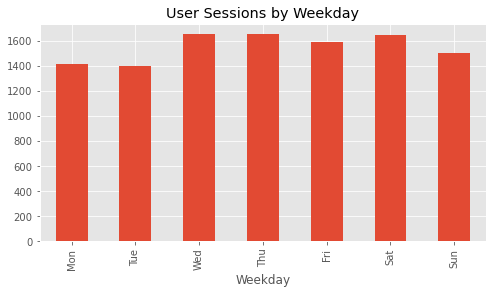

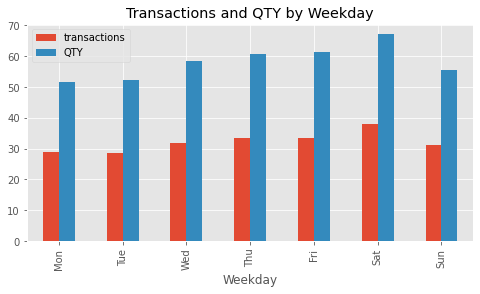

In [11]:
# Plot Data
sheet3['user_sessions'].plot(kind='bar', figsize=(8,4))
plt.title('User Sessions by Weekday')
plt.xlabel('Weekday')

sheet3[['transactions', 'QTY']].plot(kind='bar', figsize=(8,4))
plt.title('Transactions and QTY by Weekday')
plt.xlabel('Weekday')

Text(0, 0.5, 'Transaction Count')

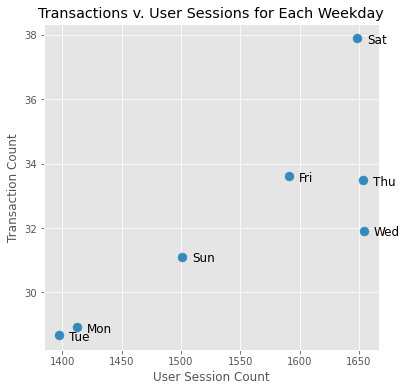

In [12]:
# Plot Transactions v. Sessions for days of the week
fig, ax = plt.subplots()
sheet3.plot(kind='scatter', x='user_sessions', y='transactions', ax=ax, s=80, figsize=(6,6))

for k, v in sheet3[['user_sessions', 'transactions']].iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('Transactions v. User Sessions for Each Weekday')
plt.xlabel('User Session Count')
plt.ylabel('Transaction Count')


In [13]:
# Create sheet4 with ecr data from each remaining browser
    # Note: Because browsers were used to distinguish between 'suspect sessions' and
    # user sessions, that distinction has no meaning when the data is grouped by browser
sheet4 = df_ses[['dim_browser','all_sessions','transactions','QTY']].groupby('dim_browser').sum()

# Add ECR column
sheet4['ECR'] = sheet4['transactions'] / sheet4['all_sessions']

# Add a column indicating which browsers are included in user_sessions data
for i in sheet4.index:
    qty_val = sheet4.loc[i,'QTY']
    transactions_val = sheet4.loc[i,'transactions']

    if (qty_val == 0) & (transactions_val == 0):
        sheet4.loc[i,'browser_in_user_sessions'] = False
    else:
        sheet4.loc[i,'browser_in_user_sessions'] = True

sheet4.sort_values('all_sessions', ascending=False, inplace=True)

sheet4.head()

,all_sessions,transactions,QTY,ECR,browser_in_user_sessions
dim_browser,,,,,
Safari,5952256,140847,263776,0.023663,True
Chrome,2527254,66247,125468,0.026213,True
Safari (in-app),518573,3046,5113,0.005874,True
Firefox,495779,17376,31279,0.035048,True
Internet Explorer,469325,14373,11016,0.030625,True


(-300000.0, 7000000.0)

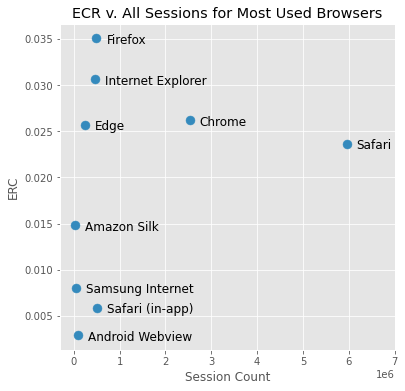

In [14]:
# Plot ECR v. Sessions for most used browsers
graph2 = sheet4.drop(sheet4[sheet4['all_sessions'] < 10000].index, axis=0)

fig, ax = plt.subplots()
graph2.plot(kind='scatter', x='all_sessions', y='ECR', ax=ax, s=80, figsize=(6,6))

for k, v in graph2[['all_sessions', 'ECR']].iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('ECR v. All Sessions for Most Used Browsers')
plt.xlabel('Session Count')
plt.ylabel('ERC')
plt.xlim(-.3e6,7e6)


(0.0, 0.009)

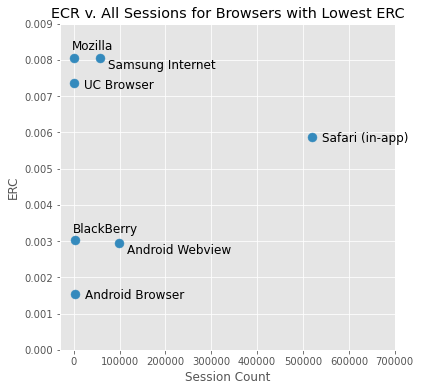

In [15]:
# Plot ECR v. Sessions for browsers with lowest ERC
graph3 = sheet4.drop(sheet4[sheet4['ECR'] > 0.01].index, axis=0)
graph3.sort_values('transactions', inplace=True)
graph3 = graph3.tail(7)

fig, ax = plt.subplots()
graph3.plot(kind='scatter', x='all_sessions', y='ECR', ax=ax, s=80, figsize=(6,6))

for k, v in graph3[['all_sessions', 'ECR']].tail(7).iterrows():
    if k in ['Mozilla', 'BlackBerry']:
        offset = (-2,8)
    elif k in ['Samsung Internet', 'Android Webview']:
        offset = (8,-10)
    else:
        offset = (10,-5)

    ax.annotate(k, v,
                xytext=offset, textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('ECR v. All Sessions for Browsers with Lowest ERC')
plt.xlabel('Session Count')
plt.ylabel('ERC')
plt.xlim(-30000,700000)
plt.ylim(0,.009)